![](https://storage.googleapis.com/kaggle-competitions/kaggle/29653/logos/header.png)

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:darkviolet; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [Overview](#1)
* [Data Visualization](#2)
    
* [Sample Submission](#20)
    

* [Modeling](#100)

<a id="1"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>Overview<center><h2>

In [ ]:
#import libraries
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

**train/** - folder containing the training files, with each top-level folder representing a subject  
**train_labels.csv** - file containing the target MGMT_value for each subject in the training data (e.g. the presence of MGMT promoter methylation)   
**test/** - the test files, which use the same structure as train/   
**sample_submission.csv** - a sample submission file in the correct format

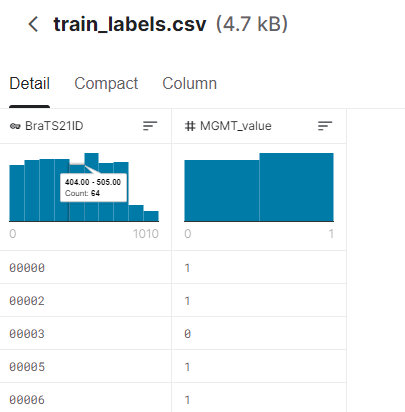

<a id="2"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>Data Visualization<center><h2>

In [ ]:
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df

Our dataset has almost equal sets with 585 patients. (305 patients with MGMT and 280 without it)

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(data=train_df, x="MGMT_value");

Our dataset is divised into 4 directories. MRI Sequences
- Fluid Attenuated Inversion Recovery (FLAIR):
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)

Each independent case has a dedicated folder identified by a five-digit number


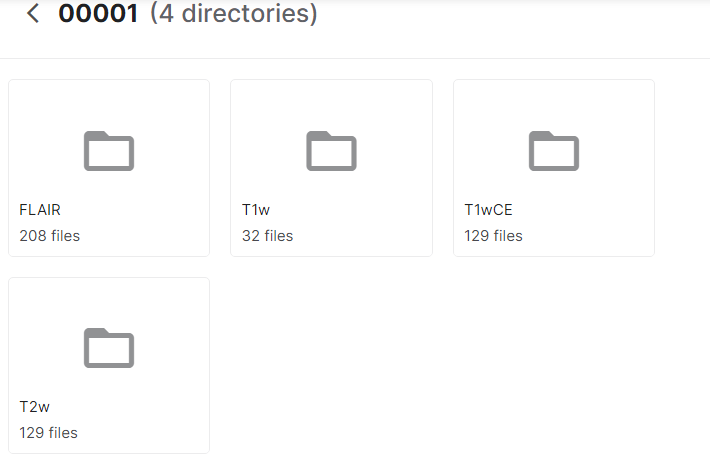

Since we are using a Medical Dataset all our images have a .dcm extension (an image file saved in the Digital Imaging and Communications in Medicine) in this case we need to use the pydicom library to use our data

In [ ]:
#read each picture and return an array with values[0..255] since dicom images typically 
#contain between 12–16 bits/pixel, which corresponds to approximately 4,096 to 65,536 shades of gray
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def visualize_sample(
    brats21id,
    #the slice represents the way we slice the brain the first images represents a small slice 
    #the bigger slice_i the bigger the slice(front of the brain)
    slice_i,
    mgmt_value,
    types=("FLAIR", "T1w", "T1wCE", "T2w")
):
    #create a 16x16 figure with 5 inch space
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", 
        str(brats21id).zfill(5), 
        
    #the id in our csv file is 0 but 00000 in our directory that's why we use zfill
    )
    
    for i, t in enumerate(types, 1):
        #a sorted list of each subject's images
        t_paths = sorted(
            #glob used to return all file paths that match a specific pattern.
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        data = load_dicom(t_paths[int(len(t_paths) * slice_i)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

In [ ]:
#takes 10 samples of our training dataset. Each row represents a patient.
#as previously seen train_df.shape[0] is 585 
for i in random.sample(range(train_df.shape[0]), 10):
    _brats21id = train_df.iloc[i]["BraTS21ID"]
    _mgmt_value = train_df.iloc[i]["MGMT_value"]
    visualize_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5)

# **Animation**

In [ ]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

#takes a couple of images and returns an animation
def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

In [ ]:
#returns a list of images
def load_dicom_line(path):
    t_paths = sorted(
        glob.glob(os.path.join(path, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    images = []
    for filename in t_paths:
        data = load_dicom(filename)
        if data.max() == 0:
            continue
        images.append(data)
        
    return images

In [ ]:
images = load_dicom_line("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR")
create_animation(images)

In [ ]:
images = load_dicom_line("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w")
create_animation(images)

In [ ]:
images = load_dicom_line("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1wCE")
create_animation(images)

In [ ]:
images = load_dicom_line("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T2w")
create_animation(images)

<a id="100"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>Modeling<center><h2>

In [ ]:
#import Libraries
#use Efficient Net Architecture
package_path = "../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/"
import sys 
sys.path.append(package_path)

import time

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import efficientnet_pytorch

from sklearn.model_selection import StratifiedKFold

This function is usually used to lock pytorch randomness for reproducibility

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

In [ ]:
df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
df_train, df_valid = sk_model_selection.train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,
    stratify=train_df["MGMT_value"],#split data based on MGMT_value
)

In [ ]:
#return tensors of resized photos, label for each patient.
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths, targets):
        self.paths = paths
        self.targets = targets
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = f"../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{str(_id).zfill(5)}/"
        #resized images
        channels = []
        for t in ("FLAIR", "T1w", "T1wCE"): # "T2w"
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            # start, end = int(len(t_paths) * 0.475), int(len(t_paths) * 0.525)
            x = len(t_paths)
            if x < 10:
                r = range(x)
            else:
                d = x // 10
                r = range(d, x - d, d)
                
            channel = []
            # for i in range(start, end + 1):
            for i in r:
                channel.append(cv2.resize(load_dicom(t_paths[i]), (256, 256)) / 255)
            channel = np.mean(channel, axis=0)
            channels.append(channel)
            
        y = torch.tensor(self.targets[index], dtype=torch.float)
        
        return {"X": torch.tensor(channels).float(), "y": y}

In [ ]:
train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

In [ ]:
#plotting 3 images for patient number 100
plt.figure(figsize=(16, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_data_retriever[100]["X"].numpy()[i], cmap="gray")

In [ ]:
#loading the model EfficientNet
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = efficientnet_pytorch.EfficientNet.from_name("efficientnet-b0")
        checkpoint = torch.load("../input/efficientnet-pytorch/efficientnet-b0-08094119.pth")
        self.net.load_state_dict(checkpoint)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

Our Model doesn't have a score function like the ones already implemented in Sklearn so It needs its own metrics

In [ ]:
#loss and Accuracy Meters: same ones used for EfficientNet
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg

Here we define our trainer, we give it our model, optimizer:minimize the error function, criterion: when to stop the algorithm, and our metrics.
Alongside the Fit function(trains, returns messages, and saves best model for validation) it has a train and a validation epoch.
An epoch is the number of passes for the entire training dataset through the model. (diff from iteration). in these function we will also be splitting our data into batches to increase speed. iteration is the number of times a batch of data has passed through the model.

In [ ]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        
        self.best_valid_score = -np.inf
        self.n_patience = 0
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )

            if self.best_valid_score < valid_score:

                self.info_message(
                    self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                )
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path)
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}'
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

#use a dataloader to have easier access to our data.Data Loader reads, extracts, and loads data 
#from comma-separated values (CSV) files or from a database connection. 
#When exporting data, it outputs CSV files.

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=8,
    shuffle=True,
    num_workers=8,
)

valid_loader = torch_data.DataLoader(
    valid_data_retriever, 
    batch_size=8,
    shuffle=False,
    num_workers=8,
)

model = Model()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch_functional.binary_cross_entropy_with_logits

trainer = Trainer(
    model, 
    device, 
    optimizer, 
    criterion, 
    LossMeter, 
    AccMeter
)

To avoid overfitting we are taking into consideration the validation score and saving the model with the best validation score.

In [ ]:
history = trainer.fit(
    20, 
    train_loader, 
    valid_loader, 
    f"best-model-0.pth", 
    100,
)

In [ ]:
#load the model
models = []
for i in range(1):
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(f"best-model-{i}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    models.append(model)

In [ ]:
models

# **Testing**

In [ ]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths):
        self.paths = paths
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = f"../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/{str(_id).zfill(5)}/"
        channels = []
        for t in ("FLAIR", "T1w", "T1wCE"): # "T2w"
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            # start, end = int(len(t_paths) * 0.475), int(len(t_paths) * 0.525)
            x = len(t_paths)
            if x < 10:
                r = range(x)
            else:
                d = x // 10
                r = range(d, x - d, d)
                
            channel = []
            # for i in range(start, end + 1):
            for i in r:
                channel.append(cv2.resize(load_dicom(t_paths[i]), (256, 256)) / 255)
            channel = np.mean(channel, axis=0)
            channels.append(channel)
        
        return {"X": torch.tensor(channels).float(), "id": _id}

In [ ]:
submission = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

test_data_retriever = DataRetriever(
    submission["BraTS21ID"].values, 
)

test_loader = torch_data.DataLoader(
    test_data_retriever,
    batch_size=4,
    shuffle=False,
    num_workers=8,
)

In [ ]:
y_pred = []
ids = []

for e, batch in enumerate(test_loader):
    print(f"{e}/{len(test_loader)}", end="\r")
    with torch.no_grad():
        tmp_pred = np.zeros((batch["X"].shape[0], ))
        for model in models:
            tmp_res = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            tmp_pred += tmp_res
        y_pred.extend(tmp_pred)
        ids.extend(batch["id"].numpy().tolist())

In [ ]:
submission = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred})
submission.to_csv("submission.csv", index=False)

In [ ]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"]);

In [ ]:
submission